Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`). 

Use a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.

- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Fit a ridge regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Instead of `RidgeRegression`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `RidgeRegression`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [1]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module3')

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 156, done.
remote: Total 156 (delta 0), reused 0 (delta 0), pack-reused 156
Receiving objects: 100% (156/156), 19.30 MiB | 21.14 MiB/s, done.
Resolving deltas: 100% (71/71), done.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master
     |████████████████████████████████| 92kB 3.1MB/s 
     |████████████████████████████████| 112kB 8.5MB/s 
     |████████████████████████████████| 133kB 55.0MB/s 
     |████████████████████████████████| 57.7MB 1.3MB/s 
     |████████████████████████████████| 235kB 43.9MB/s 
     |████████████████████████████████| 614kB 41.9MB/s 
     |████████████████████████████████| 235kB 45.6MB/s 
     |████████████████████████████████| 307kB 46.6MB/s 
     |████████████████████████████████| 215kB 54.1MB/s 
     |████████████████████████████████| 51kB 21.6MB/s 
     |██████████

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [6]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [7]:
#Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.

df['SALE_DATE'] = df['SALE_DATE'].apply(pd.to_datetime)
df['month'] = df['SALE_DATE'].apply(lambda d: d.month)

df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE,month
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,2019-01-01,1
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,2019-01-01,1
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,2019-01-01,1
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,2019-01-01,1
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,2019-01-01,1


In [8]:
#do the split
train = df[df['month'] < 4]
test = df[df['month'] == 4]

test.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE,month
18167,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,695,1562,NaN,R4,"555 WEST 23RD STREET, N11E",N11E,10011.0,1.0,0.0,1.0,0,670.0,2005.0,2,R4,949000,2019-04-01,4
18168,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,767,1609,NaN,R4,"221 WEST 17TH STREET, 6A",6A,10011.0,1.0,0.0,13.0,"5,550",36835.0,1912.0,2,R4,4683950,2019-04-01,4
18169,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,767,1612,NaN,R4,"221 WEST 17TH STREET, PH3",PH3,10011.0,1.0,0.0,13.0,"5,550",36835.0,1912.0,2,R4,5600000,2019-04-01,4
18170,1,OTHER,17 CONDO COOPS,2,721,1008,NaN,R9,"465 WEST 23RD STREET, RCU1",NaN,10011.0,0.0,0.0,0.0,0,0.0,1932.0,2,R9,1100000,2019-04-01,4
18171,1,OTHER,21 OFFICE BUILDINGS,4,746,64,NaN,O8,340 WEST 23RD STREET,NaN,10011.0,3.0,1.0,4.0,"2,469",5603.0,1900.0,4,O8,0,2019-04-01,4


In [9]:
train.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE,month
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,2019-01-01,1
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,2019-01-01,1
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,2019-01-01,1
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,2019-01-01,1
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,2019-01-01,1


In [12]:
#Do one-hot encoding of categorical features.

train.select_dtypes(exclude='number').describe().T.sort_values(by='unique')
#oh whoops we should be looking at only 01 ONE FAMILY DWELLINGS

,count,unique,top,freq,first,last
BOROUGH,18167,5,4,5883,NaN,NaN
TAX_CLASS_AT_PRESENT,18167,10,1,8911,NaN,NaN
NEIGHBORHOOD,18167,11,OTHER,15058,NaN,NaN
BUILDING_CLASS_CATEGORY,18167,43,01 ONE FAMILY DWELLINGS,4094,NaN,NaN
SALE_DATE,18167,90,2019-01-24 00:00:00,480,2019-01-01 00:00:00,2019-03-31 00:00:00
BUILDING_CLASS_AT_PRESENT,18167,140,D4,2640,NaN,NaN
BUILDING_CLASS_AT_TIME_OF_SALE,18167,140,D4,2640,NaN,NaN
APARTMENT_NUMBER,3972,1450,4,81,NaN,NaN
LAND_SQUARE_FEET,18139,3207,0,5784,NaN,NaN
ADDRESS,18167,17926,N/A ROCKAWAY BOULEVARD,5,NaN,NaN


In [14]:
train = train[train['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS']
test = test[test['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS']

train.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE,month
7,2,OTHER,01 ONE FAMILY DWELLINGS,1,4090,37,NaN,A1,1193 SACKET AVENUE,NaN,10461.0,1.0,0.0,1.0,"3,404",1328.0,1925.0,1,A1,0,2019-01-01,1
8,2,OTHER,01 ONE FAMILY DWELLINGS,1,4120,18,NaN,A5,1215 VAN NEST AVENUE,NaN,10461.0,1.0,0.0,1.0,"2,042",1728.0,1935.0,1,A5,0,2019-01-01,1
9,2,OTHER,01 ONE FAMILY DWELLINGS,1,4120,20,NaN,A5,1211 VAN NEST AVENUE,NaN,10461.0,1.0,0.0,1.0,"2,042",1728.0,1935.0,1,A5,0,2019-01-01,1
42,3,OTHER,01 ONE FAMILY DWELLINGS,1,6809,54,NaN,A1,2601 AVENUE R,NaN,11229.0,1.0,0.0,1.0,"3,333",1262.0,1925.0,1,A1,0,2019-01-01,1
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,2019-01-01,1


In [15]:
train.select_dtypes(exclude='number').describe().T.sort_values(by='unique')

,count,unique,top,freq,first,last
BUILDING_CLASS_CATEGORY,4094,1,01 ONE FAMILY DWELLINGS,4094,NaN,NaN
APARTMENT_NUMBER,2,2,8,1,NaN,NaN
TAX_CLASS_AT_PRESENT,4094,3,1,4058,NaN,NaN
BOROUGH,4094,5,4,1993,NaN,NaN
NEIGHBORHOOD,4094,9,OTHER,3826,NaN,NaN
BUILDING_CLASS_AT_TIME_OF_SALE,4094,12,A1,1543,NaN,NaN
BUILDING_CLASS_AT_PRESENT,4094,15,A1,1542,NaN,NaN
SALE_DATE,4094,90,2019-03-29 00:00:00,96,2019-01-01 00:00:00,2019-03-31 00:00:00
LAND_SQUARE_FEET,4094,1280,"4,000",412,NaN,NaN
ADDRESS,4094,4059,277 NICHOLS AVENUE,3,NaN,NaN


In [21]:
#land square feet should be a number, but I think the commas are fouling it up
string = '3,300'
int(string.replace(',',''))

3300

In [35]:
#okay I've tried a bunch of things and none of them have had any effect, time to move on and come back later
#train['LAND_SQUARE_FEET'] == pd.to_numeric(train['LAND_SQUARE_FEET']) #.str.replace(',', '').astype(int)
#train['LAND_SQUARE_FEET'] == train['LAND_SQUARE_FEET'].astype('int32')

#train.head()

ValueError: ignored

In [24]:
#test['LAND_SQUARE_FEET'] == test['LAND_SQUARE_FEET'].apply(lambda s: int(s.replace(',','')))

#test.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE,month
18182,1,OTHER,01 ONE FAMILY DWELLINGS,1,1708,24,NaN,A9,271 PLEASANT AVENUE,NaN,10029.0,1.0,0.0,1.0,928,2501.0,1890.0,1,A9,1,2019-04-01,4
18235,2,OTHER,01 ONE FAMILY DWELLINGS,1,5913,878,NaN,A1,4616 INDEPENDENCE AVENUE,NaN,10471.0,1.0,0.0,1.0,"5,000",2272.0,1930.0,1,A1,895000,2019-04-01,4
18239,2,OTHER,01 ONE FAMILY DWELLINGS,1,5488,48,NaN,A2,558 ELLSWORTH AVENUE,NaN,10465.0,1.0,0.0,1.0,"2,500",720.0,1935.0,1,A2,253500,2019-04-01,4
18244,3,OTHER,01 ONE FAMILY DWELLINGS,1,5936,31,NaN,A1,16 BAY RIDGE PARKWAY,NaN,11209.0,1.0,0.0,1.0,"2,880",2210.0,1925.0,1,A1,1300000,2019-04-01,4
18269,3,OTHER,01 ONE FAMILY DWELLINGS,1,3896,33,NaN,A5,15 VAN SICLEN COURT,NaN,11207.0,1.0,0.0,1.0,"1,974",1400.0,1910.0,1,A5,0,2019-04-01,4


In [0]:
#Use a subset of the data where the sale price was more than $100 thousand and less than $2 million.
train = train[train['SALE_PRICE'] > 100_000]
train = train[train['SALE_PRICE'] < 2_000_000]

test = test[test['SALE_PRICE'] > 100_000]
test = test[test['SALE_PRICE'] < 2_000_000]

In [44]:
train.select_dtypes(exclude='number').describe().T.sort_values(by='unique')
#okay let's one hot encode apartment number through building class at present

,count,unique,top,freq,first,last
BUILDING_CLASS_CATEGORY,2507,1,01 ONE FAMILY DWELLINGS,2507,NaN,NaN
APARTMENT_NUMBER,1,1,RP.,1,NaN,NaN
TAX_CLASS_AT_PRESENT,2507,2,1,2476,NaN,NaN
BOROUGH,2507,5,4,1204,NaN,NaN
NEIGHBORHOOD,2507,6,OTHER,2382,NaN,NaN
BUILDING_CLASS_AT_TIME_OF_SALE,2507,11,A1,919,NaN,NaN
BUILDING_CLASS_AT_PRESENT,2507,13,A1,919,NaN,NaN
SALE_DATE,2507,68,2019-01-31 00:00:00,78,2019-01-01 00:00:00,2019-03-30 00:00:00
LAND_SQUARE_FEET,2507,887,"4,000",234,NaN,NaN
ADDRESS,2507,2497,125-27 LUCAS STREET,2,NaN,NaN


In [51]:
#define target and features, drop high-card values

target = 'SALE_PRICE'
high_cardinality = ['ADDRESS', 'LAND_SQUARE_FEET', 'SALE_DATE']
features = train.columns.drop([target] + high_cardinality + ['EASE-MENT'])

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

X_train.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,month
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,A9,NaN,11230.0,1.0,0.0,1.0,1325.0,1930.0,1,A9,1
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,A1,NaN,11427.0,1.0,0.0,1.0,2001.0,1940.0,1,A1,1
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,A1,NaN,10461.0,1.0,0.0,1.0,2043.0,1925.0,1,A1,1
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,A1,NaN,11226.0,1.0,0.0,1.0,2680.0,1899.0,1,A1,1
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,A5,NaN,11203.0,1.0,0.0,1.0,1872.0,1940.0,1,A5,1


In [52]:
#okay NOW can I one hot encode

import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

print(X_train.shape)
X_train.head()

(2507, 50)


,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_B3,APARTMENT_NUMBER_nan,APARTMENT_NUMBER_RP.,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0,month
44,1,0,0,0,0,1,0,0,0,0,0,1,1,0,5495,801,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,11230.0,1.0,0.0,1.0,1325.0,1930.0,1,1,0,0,0,0,0,0,0,0,0,0,1
61,0,1,0,0,0,1,0,0,0,0,0,1,1,0,7918,72,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,11427.0,1.0,0.0,1.0,2001.0,1940.0,1,0,1,0,0,0,0,0,0,0,0,0,1
78,0,0,1,0,0,1,0,0,0,0,0,1,1,0,4210,19,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,10461.0,1.0,0.0,1.0,2043.0,1925.0,1,0,1,0,0,0,0,0,0,0,0,0,1
108,1,0,0,0,0,1,0,0,0,0,0,1,1,0,5212,69,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,11226.0,1.0,0.0,1.0,2680.0,1899.0,1,0,1,0,0,0,0,0,0,0,0,0,1
111,1,0,0,0,0,1,0,0,0,0,0,1,1,0,7930,121,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,11203.0,1.0,0.0,1.0,1872.0,1940.0,1,0,0,1,0,0,0,0,0,0,0,0,1


In [50]:
X_train.isna().sum()
#I'm just gonna throw Ease-ment out of the features

BOROUGH_3                                             0
BOROUGH_4                                             0
BOROUGH_2                                             0
BOROUGH_5                                             0
BOROUGH_1                                             0
NEIGHBORHOOD_OTHER                                    0
NEIGHBORHOOD_FLUSHING-NORTH                           0
NEIGHBORHOOD_BEDFORD STUYVESANT                       0
NEIGHBORHOOD_FOREST HILLS                             0
NEIGHBORHOOD_BOROUGH PARK                             0
NEIGHBORHOOD_ASTORIA                                  0
BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS       0
TAX_CLASS_AT_PRESENT_1                                0
TAX_CLASS_AT_PRESENT_1D                               0
BLOCK                                                 0
LOT                                                   0
EASE-MENT                                          2507
BUILDING_CLASS_AT_PRESENT_A9                    

In [53]:
#Do feature selection with SelectKBest.

# Select the 15 features that best correlate with the target
# (15 is an arbitrary starting point here)
from sklearn.feature_selection import f_regression, SelectKBest

# Similar API to what we've seen before
selector = SelectKBest(score_func=f_regression, k=15)

# IMPORTANT!
# .fit_transform on the train set
# .transform on test set
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)


# Which features were selected?
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)
    
print('\n')
print('Features not selected:')
for name in unselected_names:
    print(name)

Features selected:
BOROUGH_3
BOROUGH_2
BOROUGH_5
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_FLUSHING-NORTH
NEIGHBORHOOD_FOREST HILLS
BLOCK
BUILDING_CLASS_AT_PRESENT_A5
BUILDING_CLASS_AT_PRESENT_A3
ZIP_CODE
COMMERCIAL_UNITS
TOTAL_UNITS
GROSS_SQUARE_FEET
BUILDING_CLASS_AT_TIME_OF_SALE_A5
BUILDING_CLASS_AT_TIME_OF_SALE_A3


Features not selected:
BOROUGH_4
BOROUGH_1
NEIGHBORHOOD_BEDFORD STUYVESANT
NEIGHBORHOOD_BOROUGH PARK
NEIGHBORHOOD_ASTORIA
BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS
TAX_CLASS_AT_PRESENT_1
TAX_CLASS_AT_PRESENT_1D
LOT
BUILDING_CLASS_AT_PRESENT_A9
BUILDING_CLASS_AT_PRESENT_A1
BUILDING_CLASS_AT_PRESENT_A0
BUILDING_CLASS_AT_PRESENT_A2
BUILDING_CLASS_AT_PRESENT_S1
BUILDING_CLASS_AT_PRESENT_A4
BUILDING_CLASS_AT_PRESENT_A6
BUILDING_CLASS_AT_PRESENT_A8
BUILDING_CLASS_AT_PRESENT_B2
BUILDING_CLASS_AT_PRESENT_S0
BUILDING_CLASS_AT_PRESENT_B3
APARTMENT_NUMBER_nan
APARTMENT_NUMBER_RP.
RESIDENTIAL_UNITS
YEAR_BUILT
TAX_CLASS_AT_TIME_OF_SALE
BUILDING_CLASS_AT_TIME_OF_SALE_A9
BUILDING_CLASS_AT

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [55]:
# How many features should be selected?
# You can try a range of values for k,
# then choose the model with the best score.
# If multiple models "tie" for the best score,
# choose the simplest model.
# You decide what counts as a tie!

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

for k in range(1, len(X_train.columns)+1):
    
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test MAE: ${mae:,.0f} \n')
    
#26 features is the smallest number with a mse < 159k; there are a few lower scores, but no big wins past that point

1 features
Test MAE: $183,641 

2 features
Test MAE: $182,569 

3 features
Test MAE: $182,569 

4 features
Test MAE: $173,706 

5 features
Test MAE: $174,556 

6 features
Test MAE: $172,843 

7 features
Test MAE: $173,412 

8 features
Test MAE: $173,241 

9 features
Test MAE: $168,668 

10 features
Test MAE: $169,452 

11 features
Test MAE: $169,006 

12 features
Test MAE: $161,221 

13 features
Test MAE: $162,578 

14 features
Test MAE: $161,733 

15 features
Test MAE: $161,735 

16 features


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in

Test MAE: $161,548 

17 features
Test MAE: $161,548 

18 features
Test MAE: $161,308 

19 features
Test MAE: $161,308 

20 features
Test MAE: $159,303 

21 features
Test MAE: $159,371 

22 features
Test MAE: $159,371 

23 features
Test MAE: $159,371 

24 features
Test MAE: $159,371 

25 features
Test MAE: $159,107 

26 features
Test MAE: $158,990 

27 features
Test MAE: $158,924 

28 features
Test MAE: $158,882 

29 features
Test MAE: $159,683 

30 features


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in

Test MAE: $159,734 

31 features
Test MAE: $159,734 

32 features
Test MAE: $159,311 

33 features
Test MAE: $159,289 

34 features
Test MAE: $159,292 

35 features
Test MAE: $158,951 

36 features
Test MAE: $158,951 

37 features
Test MAE: $159,749 

38 features
Test MAE: $159,207 

39 features
Test MAE: $159,256 

40 features
Test MAE: $159,250 

41 features
Test MAE: $159,250 

42 features
Test MAE: $159,264 

43 features
Test MAE: $159,596 

44 features
Test MAE: $159,555 

45 features
Test MAE: $159,551 

46 features


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in

Test MAE: $159,932 

47 features
Test MAE: $159,932 

48 features
Test MAE: $159,950 

49 features
Test MAE: $159,946 

50 features
Test MAE: $159,932 



/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in

In [56]:
#for a 26 feature model, which features are used?

selector = SelectKBest(score_func=f_regression, k=26)

# IMPORTANT!
# .fit_transform on the train set
# .transform on test set
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)


# Which features were selected?
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)
    
print('\n')
print('Features not selected:')
for name in unselected_names:
    print(name)

Features selected:
BOROUGH_3
BOROUGH_4
BOROUGH_2
BOROUGH_5
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_FLUSHING-NORTH
NEIGHBORHOOD_FOREST HILLS
NEIGHBORHOOD_BOROUGH PARK
TAX_CLASS_AT_PRESENT_1
BLOCK
BUILDING_CLASS_AT_PRESENT_A5
BUILDING_CLASS_AT_PRESENT_A3
BUILDING_CLASS_AT_PRESENT_S1
BUILDING_CLASS_AT_PRESENT_A6
BUILDING_CLASS_AT_PRESENT_S0
ZIP_CODE
RESIDENTIAL_UNITS
COMMERCIAL_UNITS
TOTAL_UNITS
GROSS_SQUARE_FEET
BUILDING_CLASS_AT_TIME_OF_SALE_A5
BUILDING_CLASS_AT_TIME_OF_SALE_A3
BUILDING_CLASS_AT_TIME_OF_SALE_S1
BUILDING_CLASS_AT_TIME_OF_SALE_A6
BUILDING_CLASS_AT_TIME_OF_SALE_A8
BUILDING_CLASS_AT_TIME_OF_SALE_S0


Features not selected:
BOROUGH_1
NEIGHBORHOOD_BEDFORD STUYVESANT
NEIGHBORHOOD_ASTORIA
BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS
TAX_CLASS_AT_PRESENT_1D
LOT
BUILDING_CLASS_AT_PRESENT_A9
BUILDING_CLASS_AT_PRESENT_A1
BUILDING_CLASS_AT_PRESENT_A0
BUILDING_CLASS_AT_PRESENT_A2
BUILDING_CLASS_AT_PRESENT_A4
BUILDING_CLASS_AT_PRESENT_A8
BUILDING_CLASS_AT_PRESENT_B2
BUILDING_CLASS_AT_PRESE

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [0]:
features26 = ['BOROUGH_3',
'BOROUGH_4',
'BOROUGH_2',
'BOROUGH_5',
'NEIGHBORHOOD_OTHER',
'NEIGHBORHOOD_FLUSHING-NORTH',
'NEIGHBORHOOD_FOREST HILLS',
'NEIGHBORHOOD_BOROUGH PARK',
'TAX_CLASS_AT_PRESENT_1',
'BLOCK',
'BUILDING_CLASS_AT_PRESENT_A5',
'BUILDING_CLASS_AT_PRESENT_A3',
'BUILDING_CLASS_AT_PRESENT_S1',
'BUILDING_CLASS_AT_PRESENT_A6',
'BUILDING_CLASS_AT_PRESENT_S0',
'ZIP_CODE',
'RESIDENTIAL_UNITS',
'COMMERCIAL_UNITS',
'TOTAL_UNITS',
'GROSS_SQUARE_FEET',
'BUILDING_CLASS_AT_TIME_OF_SALE_A5',
'BUILDING_CLASS_AT_TIME_OF_SALE_A3',
'BUILDING_CLASS_AT_TIME_OF_SALE_S1',
'BUILDING_CLASS_AT_TIME_OF_SALE_A6',
'BUILDING_CLASS_AT_TIME_OF_SALE_A8',
'BUILDING_CLASS_AT_TIME_OF_SALE_S0']

In [59]:
#Do feature scaling.
#Aaron said this wasn't very important -- I'm skipping it for now
import numpy as np

from sklearn.preprocessing import scale

df_copy = np.array(df.copy())
df_copy = scale(df_copy)  # Very helpful for regularization!
scaled = pd.DataFrame(df_copy.data, columns=df.feature_names)
scaled.head()

ValueError: ignored

In [68]:
#Fit a ridge regression model with multiple features.

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

ridge_reg = Ridge().fit(X_train[features26], y_train)

print(f'MSE: {mean_squared_error(y_test, ridge_reg.predict(X_test[features26]))}')
#big big error!
print(f'R2: {r2_score(y_test, ridge_reg.predict(X_test[features26]))}')
#unimpressive R2!

MSE: 53241962257.36534
R2: 0.395390904808149


In [64]:
alphas = []
mses = []

for alpha in range(0, 200, 1):
    ridge_reg_split = Ridge(alpha=alpha).fit(X_train, y_train)
    mse = mean_squared_error(y_test, ridge_reg_split.predict(X_test))
    print(alpha, mse)
    alphas.append(alpha)
    mses.append(mse)
#looks like the best results come from alpha = 1

0 2.499514850960577e+29
1 53983309261.42151
2 54000995052.59773
3 54039538229.37279
4 54086493857.14449
5 54137112927.927444
6 54188992665.58208
7 54240805736.659256
8 54291798574.15881
9 54341546251.01866
10 54389819551.43
11 54436508436.88382
12 54481576230.03313
13 54525031426.837105
14 54566910008.47752
15 54607264186.05676
16 54646155174.874306
17 54683648538.13672
18 54719811192.46661
19 54754709500.15551
20 54788408077.88762
21 54820969080.246895
22 54852451798.423454
23 54882912467.74648
24 54912404212.60064
25 54940977080.475945
26 54968678132.451515
27 54995551567.92457
28 55021638868.55787
29 55046978951.31959
30 55071608323.859474
31 55095561237.79083
32 55118869837.050476
33 55141564299.61294
34 55163672971.595985
35 55185222493.309395
36 55206237917.14737
37 55226742817.45452
38 55246759392.64538
39 55266308559.94184
40 55285410043.14807
41 55304082453.903046
42 55322343366.853264
43 55340209389.18359
44 55357696224.9249
45 55374818734.43699
46 55391590989.44466
47 554080

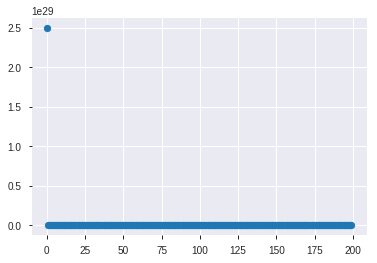

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(alphas, mses);
#hmm